Importing Libraries

In [1]:
import os
import re
import math
import pickle
import numpy as np
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
from tkinter import messagebox
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Functions To process, build and load document vectors

In [2]:
def read_documents(directory):
    universal_set = set()
    documents = {}
    for file_name in os.listdir(directory):
        if file_name.endswith('.txt'):
            doc_id = os.path.splitext(file_name)[0]
            with open(os.path.join(directory, file_name), 'r', encoding='ISO-8859-1') as file:
                content = file.read()
                documents[doc_id] = content
                universal_set.add(doc_id)
    return documents, universal_set

In [3]:
def preprocess(content):
    tokens = re.findall(r'\b\w+\b', content.lower())
    return tokens

In [4]:
def build_index_docs(documents):
    index = {}
    for doc_id, doc_content in documents.items():
        terms = preprocess(doc_content)
        for term in terms:
            if term not in index:
                index[term] = {}
            if doc_id not in index[term]:
                index[term][doc_id] = 0
            index[term][doc_id] += 1
    return index

In [5]:
def compute_idf(token, index, total_docs):
    if token in index.keys():
        df = len(index[token])
        if df == 0:
            return 0
        idf = math.log(total_docs / df)
        return idf
    else:
        return 0

In [6]:
def build_document_vectors(documents, index, total_docs):
    document_vectors = {}
    for doc_id, doc_text in documents.items():
        vector = {}
        for token in index.keys():
            if doc_id in index[token]:
                tf = index[token][doc_id]
            else:
                tf = 0
            idf = compute_idf(token, index, total_docs)
            vector[token] = tf * idf
        document_vectors[doc_id] = vector
    return document_vectors

In [7]:
def load_indexes():
    document_vectors_file = 'document_vectors.pkl'
    universal_set_file = 'universal_set.pkl'
    document_index_file = 'document_index.pkl'

    if os.path.exists(document_vectors_file) and os.path.exists(universal_set_file):
        with open(document_vectors_file, 'rb') as file:
            document_vectors = pickle.load(file)

        with open(document_index_file, 'rb') as file:
            document_index = pickle.load(file)

        with open(universal_set_file, 'rb') as file:
            universal_set = pickle.load(file)

        return document_vectors, document_index, universal_set
    else:
        universal_set = set()
        files_directory = 'C:/Users/UBL-HO.DESKTOP-7ET3E40/Desktop/BAI-6A/IR/a/ResearchPapers'

        documents, universal_set = read_documents(files_directory)

        index = build_index_docs(documents)
        docs_vectors = build_document_vectors(documents, index, len(universal_set))

        save_indexes(docs_vectors, index, universal_set)

        return docs_vectors, index, universal_set

In [8]:
def save_indexes(document_vectors, document_index, universal_set):
    with open('document_vectors.pkl', 'wb') as file:
        pickle.dump(document_vectors, file)

    with open('document_index.pkl', 'wb') as file:
        pickle.dump(document_index, file)

    with open('universal_set.pkl', 'wb') as file:
        pickle.dump(universal_set, file)

TASK#1: Text Classification (KNN)

In [9]:
def prepare_data_for_classification(document_vectors, y_labels):
    X = np.array([list(document_vectors[doc].values()) for doc in sorted(document_vectors)])
    y = np.zeros(len(document_vectors))
    for label, docs in y_labels.items():
        for doc in docs:
            y[sorted(document_vectors).index(str(doc))] = list(y_labels.keys()).index(label)
    return X, y

In [10]:
def feature_selection(X, y, k=1000):
    selector = SelectKBest(chi2, k=k)
    X_selected = selector.fit_transform(X, y)
    return X_selected

In [11]:
def find_optimal_k_knn(X_train, y_train, X_test, y_test):
    accuracies = []
    max_k = len(X_train) - 1  
    k_values = range(1, max_k + 1)  

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy for different k values')
    plt.grid(True)
    plt.show()

    optimal_k = k_values[accuracies.index(max(accuracies))]
    print(f"Optimal number of neighbors (k): {optimal_k}")
    return optimal_k

In [12]:
def find_optimal_k_knn_NoGraph(X_train, y_train, X_test, y_test):
    accuracies = []
    max_k = len(X_train) - 1  
    k_values = range(1, max_k + 1)  

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    optimal_k = k_values[accuracies.index(max(accuracies))]
    return optimal_k

In [13]:
def evaluate_classification(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [14]:
def prepare_data_for_classification(document_vectors, y_labels):
    X = np.array([list(document_vectors[doc].values()) for doc in sorted(document_vectors)])
    y = np.zeros(len(document_vectors))
    for label, docs in y_labels.items():
        for doc in docs:
            y[sorted(document_vectors).index(str(doc))] = list(y_labels.keys()).index(label)
    return X, y


In [15]:
def classify_document(document_path):
    y_labels = {
        'Explainable Artificial Intelligence': [1, 2, 3, 7],
        'Heart Failure': [8, 9, 11],
        'Time Series Forecasting': [12, 13, 14, 15, 16],
        'Transformer Model': [17, 18, 21],
        'Feature Selection': [22, 23, 24, 25, 26]
    }
    
    with open(document_path, 'r', encoding='ISO-8859-1') as file:
        content = file.read()
    
    tokens = preprocess(content)
    
    new_document_vector = {}
    for token in document_index.keys():
        if token in tokens:
            tf = tokens.count(token)
            idf = compute_idf(token, document_index, len(universal_set))
            new_document_vector[token] = tf * idf
        else:
            new_document_vector[token] = 0
    

    X, y = prepare_data_for_classification(document_vectors, y_labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_selected = feature_selection(X_train, y_train)
    X_test_selected = feature_selection(X_test, y_test)

    optimal_k = find_optimal_k_knn_NoGraph(X_train_selected, y_train, X_test_selected, y_test)

    X_train, y_train = prepare_data_for_classification(document_vectors, y_labels)
    
    X_new_doc = np.array([list(new_document_vector.values())])
    
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(X_train, y_train)
    predicted_class = knn.predict(X_new_doc)
    
    return predicted_class[0]

TASK#2: Text Clustering

In [16]:
def prepare_data_for_clustering(document_vectors):
    X = np.array([list(document_vectors[doc].values()) for doc in sorted(document_vectors)])
    return X

In [17]:
def text_clustering_kmeans(X, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

In [18]:
def evaluate_clustering(X, clusters):
    silhouette = silhouette_score(X, clusters)
    return silhouette

In [19]:
def find_optimal_k_kmeans(X, max_k):
    distortions = []
    K = range(1, max_k + 1)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k (number of clusters)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('The Elbow Method showing the optimal k')
    plt.grid(True)
    plt.show()
    
    elbow_point = None
    for i in range(1, len(distortions)-1):
        if distortions[i-1] - distortions[i] > distortions[i] - distortions[i+1]:
            elbow_point = i + 1
            break

    print(f"Elbow point at: {elbow_point} clusters")
    return elbow_point

In [20]:
def find_optimal_k_kmeans_NoGraph(X, max_k):
    distortions = []
    K = range(1, max_k + 1)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)
    
    elbow_point = None
    for i in range(1, len(distortions)-1):
        if distortions[i-1] - distortions[i] > distortions[i] - distortions[i+1]:
            elbow_point = i + 1
            break

    return elbow_point

In [27]:
def cluster_document(document_path): 
    document_vectors, document_index, universal_set = load_indexes()
    
    with open(document_path, 'r', encoding='ISO-8859-1') as file:
        content = file.read()
    
    tokens = preprocess(content)
    
    new_document_vector = {}
    for token in document_index.keys():
        if token in tokens:
            tf = tokens.count(token)
            idf = compute_idf(token, document_index, len(universal_set))
            new_document_vector[token] = tf * idf
        else:
            new_document_vector[token] = 0
    
    X = prepare_data_for_clustering(document_vectors)
    optimal_k = find_optimal_k_kmeans_NoGraph(X, 10) 
    
    X_new_doc = np.array([list(new_document_vector.values())])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    new_doc_tfidf_pca = pca.transform(X_new_doc)

    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(X_pca)
    predicted_cluster = kmeans.predict(new_doc_tfidf_pca)
    
    return predicted_cluster[0]

Main Execution

In [28]:
def classification(document_vectors, document_index, universal_set):
    y_labels = {
        'Explainable Artificial Intelligence': [1, 2, 3, 7],
        'Heart Failure': [8, 9, 11],
        'Time Series Forecasting': [12, 13, 14, 15, 16],
        'Transformer Model': [17, 18, 21],
        'Feature Selection': [22, 23, 24, 25, 26]
    }

    X, y = prepare_data_for_classification(document_vectors, y_labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_selected = feature_selection(X_train, y_train)
    X_test_selected = feature_selection(X_test, y_test)

    optimal_k = find_optimal_k_knn(X_train_selected, y_train, X_test_selected, y_test)
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
    knn_optimal.fit(X_train_selected, y_train)
    y_pred_optimal = knn_optimal.predict(X_test_selected)

    accuracy, precision, recall, f1 = evaluate_classification(y_test, y_pred_optimal)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('f1 Score: ', f1)


In [33]:
def clustering(document_vectors, document_index, universal_set):
    X = prepare_data_for_clustering(document_vectors)
    optimal_k = find_optimal_k_kmeans(X, 10)
    clusters = text_clustering_kmeans(X, 5)
    silhouette_score_new = evaluate_clustering(X, clusters)
    print("\nText Clustering Results with Silhouette Score:")
    print("Silhouette Score:", silhouette_score_new)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title('Clustering Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

In [34]:
def visualize_data():
    selected_option = combo_box.get()
    if selected_option == 'Classification':
        classification(document_vectors, document_index, universal_set)
    elif selected_option == 'Clustering':
        clustering(document_vectors, document_index, universal_set)


In [35]:
def predict_data():
    selected_option = combo_box.get()
    if selected_option == 'Classification':
        document_path = filedialog.askopenfilename(title="Select Document File", filetypes=[("Text files", "*.txt")])
        if document_path:
            predicted_class = classify_document(document_path)
            class_labels = ['Explainable Artificial Intelligence', 'Heart Failure', 'Time Series Forecasting', 'Transformer Model', 'Feature Selection']
            predicted_class_str = class_labels[int(predicted_class)]
            messagebox.showinfo("Prediction Results", f"Predicted Class: {predicted_class_str}")
        else:
            messagebox.showerror("Error", "No document selected.")
    elif selected_option == 'Clustering':
        document_path = filedialog.askopenfilename(title="Select Document File", filetypes=[("Text files", "*.txt")])
        if document_path:
            predicted_cluster = cluster_document(document_path)  
            messagebox.showinfo("Prediction Results", f"Predicted Cluster: {predicted_cluster}")
        else:
            messagebox.showerror("Error", "No document selected.")

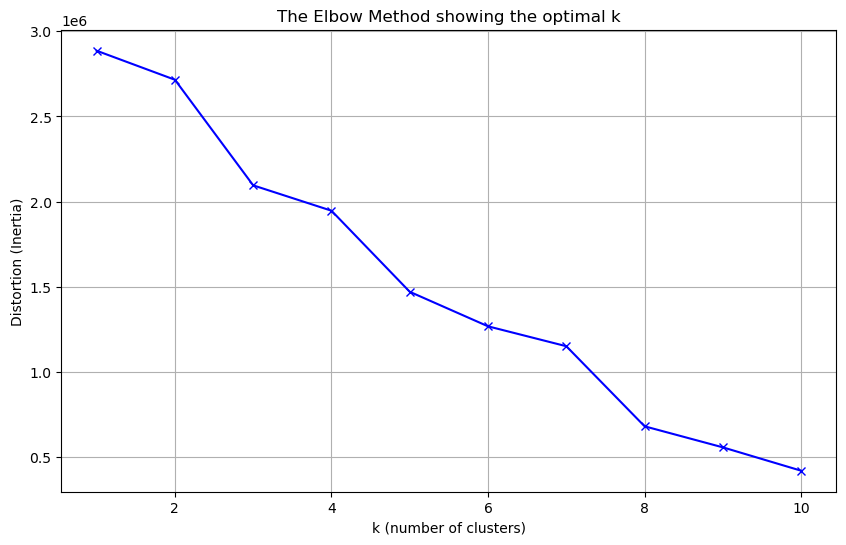

Elbow point at: 3 clusters

Text Clustering Results with Silhouette Score:
Silhouette Score: 0.12113525430198384


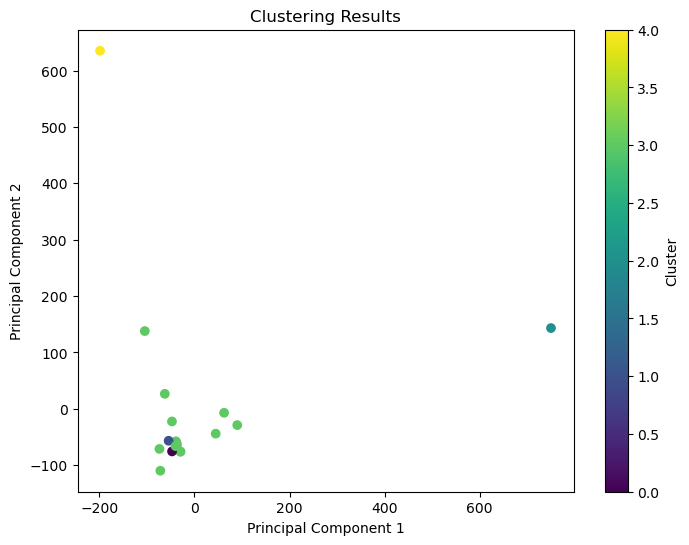

In [36]:
document_vectors, document_index, universal_set = load_indexes()

root = tk.Tk()
root.title('IR')

options = ['Classification', 'Clustering']
selected_option = tk.StringVar()
combo_box_label = ttk.Label(root, text="Select Algorithm:")
combo_box_label.grid(row=0, column=0)
combo_box = ttk.Combobox(root, values=options, textvariable=selected_option)
combo_box.grid(row=0, column=1)

visualize_button = ttk.Button(root, text='Visualize Model', command=visualize_data)
visualize_button.grid(row=1, column=0, columnspan=2)

visualize_button = ttk.Button(root, text='Predict', command=predict_data)
visualize_button.grid(row=2, column=0, columnspan=3)

root.mainloop()